# INF552 Homework2:

Student Name : Hsin-Yu, Chang (1160173733)

## 1. Combined Cycle Power Plant Data Set

### (a)  Download the Combined Cycle Power Plant Data

In [1]:
import urllib.request
import zipfile
import pandas
import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'
zipname = 'CCPP.zip'
urllib.request.urlretrieve(url, zipname)
zipfile.ZipFile(zipname).namelist()

ccpp = zipfile.ZipFile(zipname).open('CCPP/Folds5x2_pp.xlsx')
ccpp = pandas.read_excel(ccpp)


### (b)  Exploring the data:

#### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [2]:
ccpp.shape

(9568, 5)

In [3]:
ccpp.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

__\>__ There are 9568 rows and 5 columns in this data set. Each row represent a data point, and columns stand for four features and one output. Features include temperature (AT), exhaust vacuum (V), ambient pressure (AP) and relative humidity (RH). Column 'PE' represents the net hourly electrical energy output.

#### ii. Pairwise Scatterplots

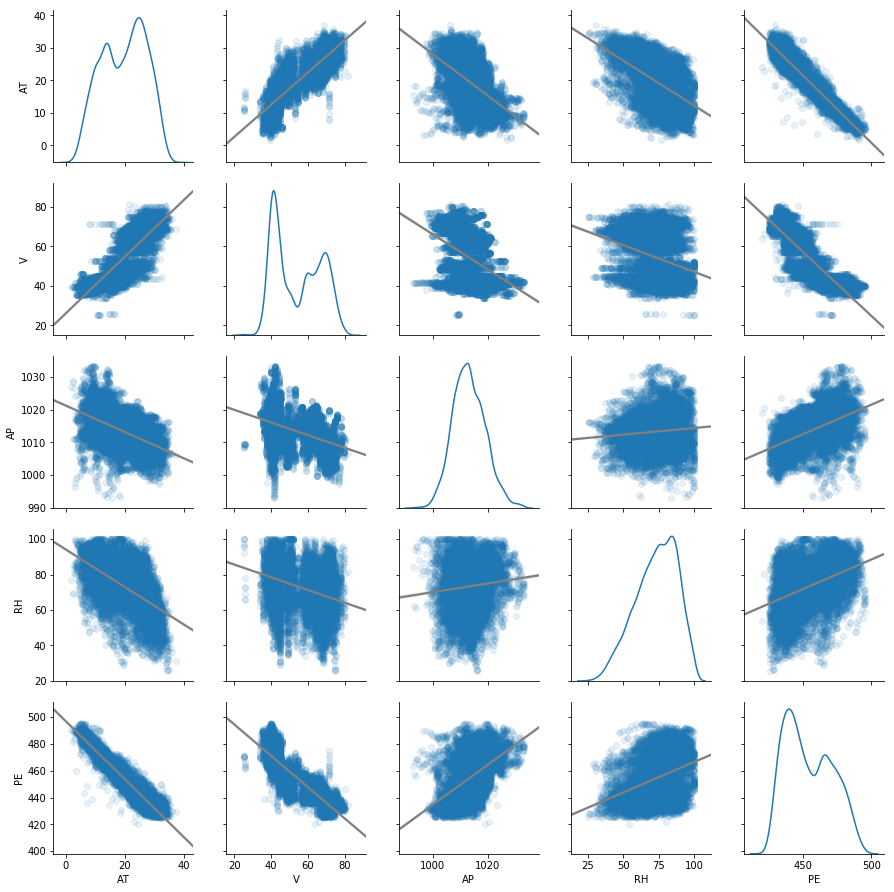

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(ccpp, diag_kind="kde", kind='reg', plot_kws={'line_kws':{'color':'gray'}, 'scatter_kws': {'alpha': 0.1}})
plt.show()

__\>__ From this pairwise scatterplots, I would first guess that AT & V has positive relationship, predictors V and AT are correlated. Also, AT and V have negative relationship with our output 'PE'.

In [6]:
print(np.corrcoef(ccpp.AT,ccpp.V))

[[1.         0.84410673]
 [0.84410673 1.        ]]


__\>__ By calculating correlation between predictors 'AT' and 'V', it shows that they are strongly correlated (0.84), it might cause large variation in estimating coefficient while fitting model with different data set. 

#### iii. Summarize CCPP data

In [7]:
#ccpp.describe()
import numpy as np
#import statistics

mean = [round(ccpp[col].mean(), 2) for col in ccpp.columns]
median = [round(ccpp[col].median(), 2) for col in ccpp.columns]
std = [round(np.std(ccpp[col]), 2) for col in ccpp.columns]
rangee = [round(ccpp[col].max()-ccpp[col].min(), 2) for col in ccpp.columns]
firstQ = [round(np.percentile(ccpp[col], 25), 2) for col in ccpp.columns]
thirdQ = [round(np.percentile(ccpp[col], 75), 2) for col in ccpp.columns]
IQR = list(np.array(thirdQ)-np.array(firstQ))
IQR = [round(num, 2) for num in IQR]


describstat = pandas.DataFrame(
    {'mean': mean,
     'median': median,
     'std' : std,
     'range': rangee,
     '25%' : firstQ,
     '75%' : thirdQ,
     'IQR' : IQR,
    })

#change every single index to column name
describstat.index = list(ccpp.columns)
describstat

,mean,median,std,range,25%,75%,IQR
AT,19.65,20.34,7.45,35.30,13.51,25.72,12.21
V,54.31,52.08,12.71,56.20,41.74,66.54,24.80
AP,1013.26,1012.94,5.94,40.41,1009.10,1017.26,8.16
RH,73.31,74.97,14.60,74.60,63.33,84.83,21.50
PE,454.37,451.55,17.07,75.50,439.75,468.43,28.68


### (c) Simple Linear Regression for each Predictor

$$H_0:\beta_i = 0$$
$$H_1:\beta_i \neq 0$$

In [35]:
import statsmodels.formula.api as smf

In [36]:
param = []

#### Outlier detection: Hampel identifier

$$Z_j = \frac{\mid X_j-median\mid}{\frac{MAD}{0.6745}}$$

where MAD is the median value of all distance from data point to the median. 
<br>Rule: if the Z score is larger than 2.45, we detect it as outlier.

In [37]:
def Hampelidentifier(array):
    array = np.array(array)
    mad = np.median(abs(array-np.median(array)))
    hamp = abs(array-np.median(array))/(mad/0.6745) 
    
    return hamp > 2.45
    

##### for predictor ''Temperature''

In [38]:
AToutlier = Hampelidentifier(ccpp.AT) 
sum(AToutlier) # number of outliers

0

__\>__ No outlier is detected based on hampel identifier.

In [39]:
data = ccpp[['AT', 'PE']]
regr = smf.ols(formula = 'PE ~ AT', data = data).fit()

param.append(round(regr.params[1], 2))
#regr.summary()
print('coefficient:\n', regr.params)
print('\n')
print('p-value:\n', regr.pvalues)  


coefficient:
 Intercept    497.03412
AT            -2.17132
dtype: float64


p-value:
 Intercept    0.0
AT           0.0
dtype: float64


__\>__ I would reject the null hypothesis under any siginificance level, since the p-value is extremely small, and conclude that there is a significant statistically relationship between variable 'Temperature' and output 'PE'. From the coefficient of 'AT', there is a negative relationship between predictor and outcome. 

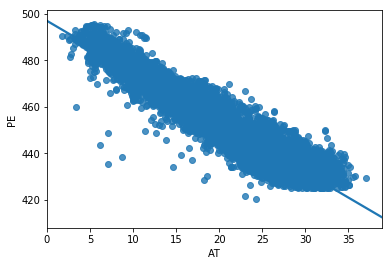

In [40]:
sns.regplot(x="AT", y="PE", data=data);

##### for predictor ''Exhaust Vacuum''

In [41]:
Voutlier = Hampelidentifier(ccpp.V) 
sum(Voutlier)

0

__\>__ No outlier is detected based on hampel identifier.

In [42]:
data = ccpp[['V', 'PE']]
regr = smf.ols(formula = 'PE ~ V', data = data).fit()

param.append(round(regr.params[1], 2))
#regr.summary()
print('coefficient:\n', regr.params)
print('\n')
print('p-value:\n', regr.pvalues)  

coefficient:
 Intercept    517.801526
V             -1.168135
dtype: float64


p-value:
 Intercept    0.0
V            0.0
dtype: float64


__\>__ P-value of 'V' is too small to accept the null hypothesis, that means we reject the null, and conclude that there is a significant association between 'V' and 'PE'.  

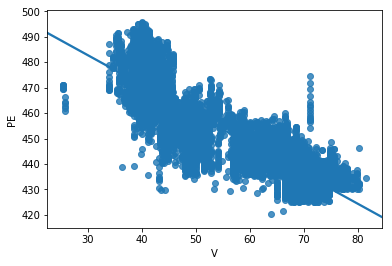

In [43]:
sns.regplot(x="V", y="PE", data=data);

##### for predictor ''Ambient Pressure''

In [44]:
APoutlier = Hampelidentifier(ccpp.AP) 
sum(APoutlier)

146

__\>__ Based on Hampel identifier (Z'>2.45), we could detect 146 outliers in 'AP' column.

In [45]:
data = ccpp[['AP', 'PE']]
omitdata = data[~APoutlier]

- Fitting model with entire data:

In [46]:
regr = smf.ols(formula = 'PE ~ AP', data = data).fit()

print('Rsquared = ', round(regr.rsquared, 2))
print('coefficient of AP =', round(regr.params[1], 2))

Rsquared =  0.27
coefficient of AP = 1.49


- Fitting model without outliers:

In [47]:
omitregr = smf.ols(formula = 'PE ~ AP', data = omitdata).fit()

#param.append(round(regr.params[1], 2))
print('Rsquared = ', round(omitregr.rsquared, 2))
print('coefficient of AP =', round(omitregr.params[1], 2))

Rsquared =  0.27
coefficient of AP = 1.58


__\>__ Using data with or without outliers, models have slight difference. For 'AP' column, I would choose to use entire data for fitting the model.

In [48]:
param.append(round(regr.params[1], 2))
print('coefficient:\n', regr.params)
print('\n')
print('p-value:\n', regr.pvalues)  

coefficient:
 Intercept   -1055.260989
AP              1.489872
dtype: float64


p-value:
 Intercept    0.0
AP           0.0
dtype: float64


__\>__ I would conclude that variable 'AP' has a statistically significant relationship with output 'PE', because the p-value of it is close to zero. And from our model, the relationship between predictor and output is positive. 

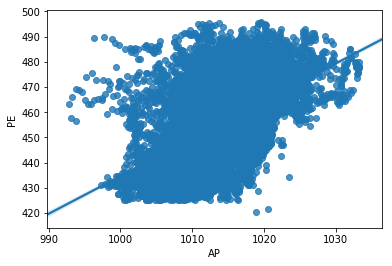

In [49]:
sns.regplot(x="AP", y="PE", data=data);

##### for predictor ''Relative Humidity''

In [50]:
RHoutlier = Hampelidentifier(ccpp.RH) 
sum(RHoutlier)

66

__\>__ Detecting 66 outliers in 'RH' column.

In [51]:
data = ccpp[['RH', 'PE']]
omitdata = data[~RHoutlier]

- Fitting model with entire data:

In [52]:
regr = smf.ols(formula = 'PE ~ RH', data = data).fit()

print('Rsquared = ', round(regr.rsquared, 2))
print('coefficient of RH =', round(regr.params[1], 2))
#regr.summary()

Rsquared =  0.15
coefficient of RH = 0.46


- Fitting model without outliers:

In [53]:
regr = smf.ols(formula = 'PE ~ RH', data = omitdata).fit()

print('Rsquared = ', round(omitregr.rsquared, 2))
print('coefficient of RH =', round(omitregr.params[1], 2))
#omitregr.summary()

Rsquared =  0.27
coefficient of RH = 1.58


__\>__ For 'RH' column, fitting without ouliers improves the ability of our model at interpreting the variance of 'PE' (Rsquare is higher when without outliers), and also has a difference at the slope of our regression model. Therefore, I would choose to omit outliers when fitting model with 'RH'.

In [54]:
param.append(round(omitregr.params[1], 2))
print('coefficient:\n', regr.params)
print('\n')
print('p-value:\n', regr.pvalues)  

coefficient:
 Intercept    420.654976
RH             0.459548
dtype: float64


p-value:
 Intercept    0.0
RH           0.0
dtype: float64


__\>__ When we use 'Relative Humidity' to predict our ouput, we conclude that a statistically significant relationship exists, since the p-value of 'RH' is smaller than any significance level.

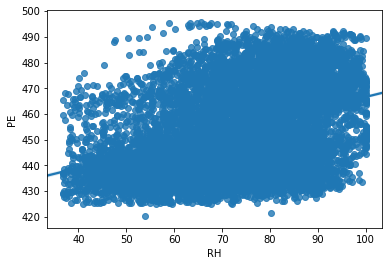

In [55]:
sns.regplot(x="RH", y="PE", data=omitdata);

#### Conclusion of (c):
Fitting linear regression with each predictor, we could find that there is a statistically relationship between each predictors and output 'PE', since the p-value for each predictor is close to zero, which gives us evidence proving these relationship. 'AT' and 'V' have negative association with 'PE'. On the other hand,'AP' and 'RH' have positive association with 'PE'.

### (d) Multiple Linear Regression

In [56]:
#muliple linear regression
regr = smf.ols(formula = 'PE ~ AT + V + AP + RH', data = ccpp).fit() #sm.OLS(y, x) 

#dir(regr)
#regr.summary()
print(regr.summary())
#regr.params#, regr.pvalues

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:29:10   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.6093      9.749     46.634      0.0

#### Conclusion of (d):
From the result of multiple linear regression, the p-value of every predictor is approximate to zero, therefore we reject the null hypothesis with any significance level. All predictors have statistically significant relationship with our output.

### (e) Coeffcients Plot between Simple Linear Regression and Multiple Linear Regression 

Text(0.5,1,'Coeffcients between SLR and MLR')

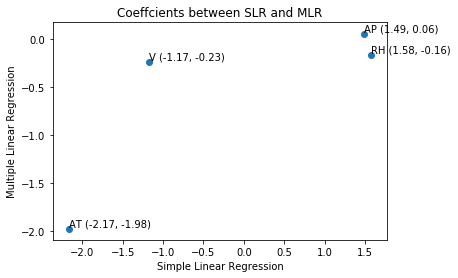

In [57]:
coeff = pandas.DataFrame(
    {   'SLR': param,
        'MLR': regr.params[1:]
    })

import matplotlib.pyplot as plt
plt.scatter(coeff.SLR, coeff.MLR)

for x, y, index in zip(coeff.SLR, coeff.MLR, coeff.index): 
    plt.text(x, y+0.02, index +' ('+ str(round(x, 2)) + ', '+ str(round(y, 2)) +')')
plt.xlabel('Simple Linear Regression')
plt.ylabel('Multiple Linear Regression')
plt.title('Coeffcients between SLR and MLR')

#### Conclusion of (e):

Every predictor has a relationship loss with reponse (electrical energy output) after fitting a multiple linear regression, which means weight (absolute coefficient value) of every predictor decreases. Even more, the relationship between 'Relative Humidity' and output changes from positive to negative.  

### (f) Nonlinear Association between Predictor and Reponse

$$Y=\beta_0+\beta_1X+\beta_2X^2+\beta_3X^3+\epsilon$$

##### for predictor ''Temperature''

In [59]:
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

data = ccpp[['AT', 'PE']]
regr = smf.ols(formula = 'PE ~ AT + I(AT**2) + I(AT**3)', data = data).fit()

print(regr.summary())
#regr.params, regr.pvalues

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:30:02   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    492.7281      0.673    732.248      0.0

__\>__ By fitting non-linear model with variable 'Temperature', we could see every p-value of each term is small, that leads us to reject the null hypothesis, which turns out evidence to prove the non-linear relationship between predictor 'AT' and output.  

##### for predictor ''Exhaust Vacuum''

In [60]:
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

data = ccpp[['V', 'PE']]
regr = smf.ols(formula = 'PE ~ V + I(V**2) + I(V**3)', data = data).fit()

print(regr.summary())
#regr.params#, regr.pvalues

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:30:10   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    554.1468      9.151     60.557      0.0

__\>__ From the result, we could see p-value of quadratic term and cubed term is larger than significance level, if we set it as 0.01, that leads us not to reject the null hypothesis of these terms. There is no sufficient evidence to prove that there is a non-linear relationship between 'V' and 'PE'.

##### for predictor ''Ambient Pressure''

In [61]:
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

data = ccpp[['AP', 'PE']]
regr = smf.ols(formula = 'PE ~ AP + I(AP**2) + I(AP**3)', data = data).fit()

print(regr.summary())
#regr.params#, regr.pvalues


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:30:17   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0747      0.009      8.415      0.0


__\>__ All p-values of each term in this non-linear model are below significance level, which gives us an evidence to show that a non-linear relationship exists between predictor 'AP' and output.  

##### for predictor ''Relative Humidity''

In [62]:
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

data = ccpp[['RH', 'PE']]
regr = smf.ols(formula = 'PE ~ RH + I(RH**2) + I(RH**3)', data = data).fit()

print(regr.summary())
#regr.params#, regr.pvalues

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    468.4135     10.545     44.422      0.0

__\>__ Contructing a non-linear model with variable 'RH', we could conclude there is a non-linear relationship between 'RH' and output by seeing all p-value of each term is smaller than significance level.  

#### Conclusion of (f):
In sum, there are non-linear relationship between output 'PE' and one of the variable in 'AT', 'AP' and 'RH'. With column 'V', there seems that the cubed term (V^3) has a small p-value (0.014), but when we compared to other predictors, it is not that significant, therefore I tend to reject the non-linear relationship between 'V' and 'PE'.

### (g) Mutiple Linear Regression with Pairwise Interaction terms

In [63]:
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

regr = smf.ols(formula = 'PE ~ AT + V + AP + RH + I(AT*V) + I(AT*AP) + I(AT*RH) + I(V*AP) + I(V*RH) + I(AP*RH)', 
               data = ccpp).fit()

print(regr.summary())
#regr.params#, regr.pvalues

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:30:44   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

#### Conclusion of (g):

With fitting model with pairwise interactions terms, we could see that p-values of 'AT', 'AP' and 'RH' are close to the 0.05 significance level bound, which we tend to have doubt on their relationship with 'PE'. However, there exists interaction terms statistically significant at 0.05 significance level, such as AT & V, AT & RH, V & AP and AP & RH. Based on the hierarchical principle, we still remain those main effects in the model.  

In [71]:
msedf = pandas.DataFrame(columns=['trainmse', 'testmse'])

### (h)

In [72]:
import random
import math
nums = [x for x in range(0,9568)]
random.shuffle(nums)

In [73]:
training = ccpp.iloc[nums[:math.ceil(len(nums)*0.7)], :]
training.shape

(6698, 5)

In [74]:
test = ccpp.iloc[nums[math.ceil(len(nums)*0.7):], :]
test.shape

(2870, 5)

##### Fit model with all predictors

In [75]:
regr = smf.ols(formula = 'PE ~ AT + V + AP + RH', 
                data = training).fit()
regr.summary()
trainpredict = regr.predict(training.iloc[:,:4])
trainmse = round(sum((trainpredict-training.PE).values**2)/len(trainpredict)-len(regr.params), 2)

testpredict = regr.predict(test.iloc[:,:4])
testmse = round(sum((testpredict-test.PE).values**2)/len(testpredict)-len(regr.params), 2)

msedf.loc['AllpredLR']=[trainmse, testmse]
trainmse, testmse

(15.51, 16.39)

##### Fit model with all predictors, interaction terms, and quadratic terms

In [76]:
regr = smf.ols(formula = 'PE ~ AT + V + AP + RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2) + I(AT*V) + I(AT*AP) + I(AT*RH) + I(V*AP) + I(V*RH) + I(AP*RH)', 
                data = training).fit()
print(regr.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     7371.
Date:                Sun, 23 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:32:23   Log-Likelihood:                -19161.
No. Observations:                6698   AIC:                         3.835e+04
Df Residuals:                    6683   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6249.4913   1418.374     -4.406      0.0

__\>__  We removing terms with its p-value higher than 0.05, which is 'V^2', 'AT & AP', 'V & AP' and 'V & RH'. I do not remove 'V' main effect based on hierachical priciple, even though its p-value is above 0.05, since there is an interaction term (AT & V) included in the remaining model.
<br>
<br>__\>__ (Note) As I mentioned in previous question (b), 'AT' and 'V' are correlated, it affects the result when I fit model with different training set, it turns out different p-values, sometimes 'AT' has high p-value, but sometimes it does not. There are high variation fitting the model with different training set.

In [77]:
regr = smf.ols(formula = 'PE ~ AT + V + AP + RH + I(AT**2) + I(AP**2) + I(RH**2) + I(AT*V) + I(AT*RH) + I(AP*RH)', 
                data = training).fit()

#regr.summary()
trainpredict = regr.predict(training.iloc[:,:4])
trainmse = round(sum((trainpredict-training.PE).values**2)/len(trainpredict)-len(regr.params), 2)

testpredict = regr.predict(test.iloc[:,:4])
testmse = round(sum((testpredict-test.PE).values**2)/len(testpredict)-len(regr.params), 2)

msedf.loc['FullpredLR']=[trainmse, testmse]
trainmse, testmse

(6.92, 7.67)

##### Using Backward Selection ( removing a term each time based on criteria - significance level = 0.05)

In [78]:
def backwardselection(data, formu):
    import re
    import statsmodels.formula.api as smf
    response = re.split('~', formu)[0]
    while True:
        regr = smf.ols(formula = formu, data = data).fit()
        if sum(regr.pvalues[1:]>0.05) >0:
            formu = response +' ~ ' + ' + '.join(regr.pvalues.index[1:][regr.pvalues[1:] != max(regr.pvalues[1:])])
            print('remove ' + str(regr.pvalues.index[1:][regr.pvalues[1:] == max(regr.pvalues[1:])]))
        else:
            return regr 


In [79]:
formula = 'PE ~ AT + V + AP + RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2) + I(AT*V) + I(AT*AP) + I(AT*RH) + I(V*AP) + I(V*RH) + I(AP*RH)'
regr = backwardselection(training, formula)
#regr.summary()

remove Index(['I(V * RH)'], dtype='object')
remove Index(['I(V ** 2)'], dtype='object')
remove Index(['I(V * AP)'], dtype='object')


In [80]:
trainpredict = regr.predict(training.iloc[:,:4])
trainmse = round(sum((trainpredict-training.PE).values**2)/len(trainpredict)-len(regr.params), 2)

testpredict = regr.predict(test.iloc[:,:4])
testmse = round(sum((testpredict-test.PE).values**2)/len(testpredict)-len(regr.params), 2)

msedf.loc['BackwardLR']=[trainmse, testmse]
trainmse, testmse

(5.89, 6.66)

#### Conclusion of (h):
With interactions and nonlinearilies term involved in the model, it cause a dramatic decrease in predicting errors both in training set and test set.

### (i) Knn Regression :

##### Fit regression with raw data:

In [81]:
from sklearn import neighbors
trainerror = []
testerror = []

for k in range(1,101):
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(training.iloc[:,:4], training.PE)  #fit the model
    trainpredict = knn.predict(training.iloc[:,:4])
    trainerror.append(round(sum((trainpredict-training.PE).values**2)/len(trainpredict), 2))
    testpredict = knn.predict(test.iloc[:,:4])
    testerror.append(round(sum((testpredict-test.PE).values**2)/len(testpredict), 2))

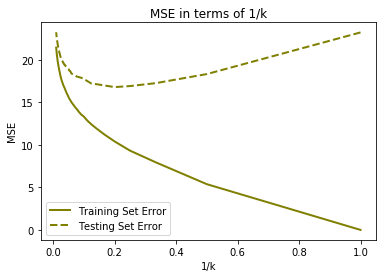

In [82]:
errordf = pandas.DataFrame({
    '1/k' : list(1/np.array((range(1,101)))),
    'trainerror' : trainerror,
    'testerror' : testerror
})

errordf[errordf.testerror == min(errordf.testerror)]

import matplotlib.pyplot as plt
plt.plot( '1/k', 'trainerror', data = errordf, marker='', color='olive', linewidth=2, label="Training Set Error")
plt.plot( '1/k', 'testerror', data = errordf, marker='', color='olive', linewidth=2, linestyle='dashed', label="Testing Set Error")
plt.legend()
plt.title('MSE in terms of 1/k')
plt.xlabel('1/k')
plt.ylabel('MSE')
plt.show()



In [83]:
msedf.loc['KnnR']=errordf[errordf.testerror == min(errordf.testerror)].loc[:,['trainerror', 'testerror']].values.tolist()[0]
print(errordf[errordf.testerror == min(errordf.testerror)])

   1/k  trainerror  testerror
4  0.2       10.41       16.8


##### Fit regression with standarized data:

In [84]:
# standardizing data
stdtraining = training.apply(lambda col: (col-col.mean())/np.std(col), axis = 0)
stdtest = test.apply(lambda col: (col-col.mean())/np.std(col), axis = 0) 

In [85]:
from sklearn import neighbors
stdtrainerror = []
stdtesterror = []

for k in range(1,101):
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(stdtraining.iloc[:,:4], stdtraining.PE)  #fit the model
    stdtrainpredict = knn.predict(stdtraining.iloc[:,:4])
    stdtrainerror.append(sum((stdtrainpredict-stdtraining.PE).values**2)/len(stdtrainpredict))
    stdtestpredict = knn.predict(stdtest.iloc[:,:4])
    stdtesterror.append(sum((stdtestpredict-stdtest.PE).values**2)/len(stdtestpredict))

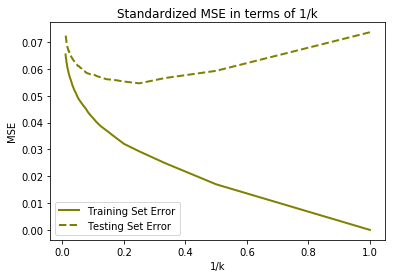

In [86]:
stderrordf = pandas.DataFrame({
    '1/k' : list(1/np.array((range(1,101)))),
    'stdtrainerror' : stdtrainerror,
    'stdtesterror' : stdtesterror
})

stderrordf[stderrordf.stdtesterror == min(stderrordf.stdtesterror)]

import matplotlib.pyplot as plt
plt.plot( '1/k', 'stdtrainerror', data = stderrordf, marker='', color='olive', linewidth=2, label="Training Set Error")
plt.plot( '1/k', 'stdtesterror', data = stderrordf, marker='', color='olive', linewidth=2, linestyle='dashed', label="Testing Set Error")
plt.legend()
plt.title('Standardized MSE in terms of 1/k')
plt.xlabel('1/k')
plt.ylabel('MSE')
plt.show()

In [87]:
print(stderrordf[stderrordf.stdtesterror == min(stderrordf.stdtesterror)])

    1/k  stdtrainerror  stdtesterror
3  0.25       0.029254      0.054615


#### Conclusion of (i):
Using both raw data and standardized data to fit KNN regression, plots of training error and test error look similar, which get the smallest test error when selecting k around 5 (raw) and 4 (normalized).  <br>(I have randomly selected training data set to fit model multiple times, best K changes, but always around 4, 5, 6 or 7)

### (j) Compare the results of KNN Regression with linear regression and provide your analysis.

In [88]:
msedf

,trainmse,testmse
AllpredLR,15.51,16.39
FullpredLR,6.92,7.67
BackwardLR,5.89,6.66
KnnR,10.41,16.80


<br>MSE is calculated by dividing SSE with n-(loss of degrees of freedom), which means some penalty to model complexity.
<br>
<br>\> AllpredLR: Regression model with all predictors.
<br>\> FullpredLR: Regression model with all predictors, interactions and quadratic nonlinearities (with removing terms whose p-valaue is above 0.05)
<br>\> BackwardLR: Regression model with all predictors, interactions and quadratic nonlinearities (with backward selection)
<br>\> KnnR: Knn regression model with raw data.


#### Conclusion of (j):
With my randomly selected training set, I get the best training error and test error when using backward selection. Besides, we can see Knn regression has an obvious difference between training error and testing error, model perfoms well in training set, but gets the highest test MSE comparing to other regression models, the reason for this is beacause we use k=5, which have the lowest test MSE comparing to other k, this amount of neighbors has risk to be overfitting.